<a href="https://colab.research.google.com/github/nibaskumar93n-debug/Morphoinformatics/blob/main/gastric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE





In [45]:
import pandas as pd

# --- Load data ---
otu = pd.read_csv("/content/feature-table1.csv", index_col=0)
meta = pd.read_csv("/content/metadata_dipto1.tsv", sep="\t", index_col=0)

# --- Clean and normalize sample IDs ---
otu.columns = otu.columns.str.strip().str.upper().str.replace(" ", "_")
meta.index = meta.index.str.strip().str.upper().str.replace(" ", "_")

# --- Align common samples ---
common_samples = otu.columns.intersection(meta.index)
otu = otu[common_samples]
meta = meta.loc[common_samples]

print(f"✅ Common samples found: {len(common_samples)}")
print("Example sample IDs:", list(common_samples)[:5])



✅ Common samples found: 31
Example sample IDs: ['SRR35138131', 'SRR35138133', 'SRR35138135', 'SRR35138138', 'SRR35138140']


In [46]:
# Check first few sample IDs from both files
print("OTU sample IDs (first 5):", otu.columns[:5].tolist())
print("Metadata sample IDs (first 5):", meta.index[:5].tolist())

# Check total counts
print("\nNumber of OTU samples:", len(otu.columns))
print("Number of metadata samples:", len(meta.index))


OTU sample IDs (first 5): ['SRR35138131', 'SRR35138133', 'SRR35138135', 'SRR35138138', 'SRR35138140']
Metadata sample IDs (first 5): ['SRR35138131', 'SRR35138133', 'SRR35138135', 'SRR35138138', 'SRR35138140']

Number of OTU samples: 31
Number of metadata samples: 31


In [47]:
# Convert counts to relative abundance
otu_rel = otu.div(otu.sum(axis=0), axis=1)



In [48]:
n_samples = otu_rel.shape[1]
prevalence_thresh = 0.05 * n_samples  # ≥5% prevalence
mean_thresh = 0.0001                  # 0.01% mean relative abundance

# Prevalence: features present in ≥5% of samples
prevalence = (otu_rel > 0).sum(axis=1)
variance = otu_rel.var(axis=1)
mean_abundance = otu_rel.mean(axis=1)

# Apply all filters
otu_filt = otu_rel.loc[
    (prevalence >= prevalence_thresh) &
    (variance > 0) &
    (mean_abundance >= mean_thresh)
]

print(f"✅ Filtered features: {otu_filt.shape[0]} (from {otu_rel.shape[0]})")




✅ Filtered features: 370 (from 2673)


In [49]:
X = otu_filt.T  # samples as rows
y = meta['var']

# Encode labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))





Class mapping: {'S_A': np.int64(0), 'T_A': np.int64(1)}


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

# Balance classes
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)

print("Training samples after balancing:", X_train_scaled.shape[0])


Training samples after balancing: 22


In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Define model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_bal, cv=cv, scoring='accuracy')

print("✅ Mean CV Accuracy:", np.mean(cv_scores).round(3))
print("Fold Accuracies:", np.round(cv_scores, 3))

# Train on full balanced training data
model.fit(X_train_scaled, y_train_bal)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /w

✅ Mean CV Accuracy: 0.85
Fold Accuracies: [1.  1.  1.  0.5 1.  1.  1.  1.  0.  1. ]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [52]:
model.fit(X_train_scaled, y_train_bal)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:03:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

         S_A       0.50      0.40      0.44         5
         T_A       0.50      0.60      0.55         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



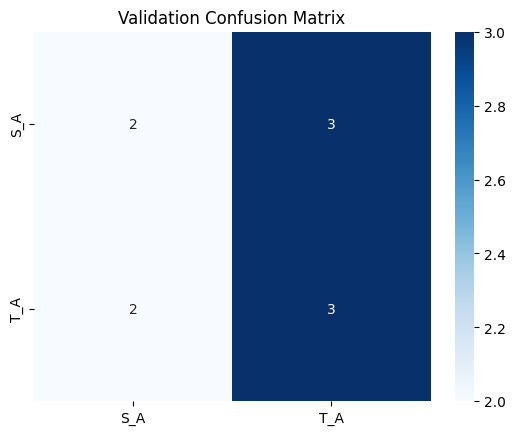

In [53]:
y_pred = model.predict(X_val_scaled)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_val, y_pred, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Validation Confusion Matrix")
plt.show()


In [54]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_scaled)

importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

top_features = importance_df.head(20)
print(top_features)


ValueError: could not convert string to float: '[5E-1]'